In [1]:
# importing packages
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer.backends import AerSimulator
from qiskit.circuit.library import RYGate
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from typing import List
import pandas as pd
from matplotlib.lines import Line2D
import os
import pickle

In [3]:
# Classical environment

class ClassicToyEnv:
    
    def __init__(self):
              
        # ========================================
        # MDP definition
        self.nS= 4 # Number of MDP states
        self.nA= 2 # Number of MDP actions
        self.nR= 4 # Number of possible rewards
        
        # Transition function
        self.T= np.zeros((self.nS, self.nA, self.nS))
        self.T[0, 0, 1]= 0.6
        self.T[0, 0, 2]= 0.4
        self.T[0, 1, 0]= 0.1 
        self.T[0, 1, 1]= 0.9 
        self.T[1, 0, 0]= 0.2 
        self.T[1, 0, 1]= 0.8
        self.T[1, 1, 2]= 0.7
        self.T[1, 1, 3]= 0.3
        self.T[2, 0, 0]= 0.3
        self.T[2, 0, 2]= 0.7
        self.T[2, 1, 1]= 0.2
        self.T[2, 1, 3]= 0.8
        self.T[3, 0, 2]= 0.6
        self.T[3, 0, 3]= 0.4
        self.T[3, 1, 3]= 1.0

        # Reward function
        self.R= np.array([10, -5, 1, -10])        
    
    # returns the number of states
    def numberOfStates(self):
        return self.nS
       
    # returns the number of actions 
    def numberOfActions(self):
        return self.nA
    
    # Returns the transition probability from state s and action a to state sp
    def transitionProb(self, s, a, sp):
        return self.T[s, a, sp]
    
    
    # Returns the reward value for the transition (s,a)->sp, i.e. r(s,a,sp)
    def rewardValue(self, s, a, sp):
        return self.R[sp]

In [4]:
# Quantum Environment for Two State Transitions with Return

class QuantumToyEnv(ClassicToyEnv):
    
    def __init__(self):
        super().__init__()
    
        # ========================================
        # Quantum MDP representation 
        self.nqS= 2 # Number of qubits for state representation= log2(nS)
        self.nqA= 1 # Number of qubits required for action representation= log2(nA)
        self.nqR= 2 # Number of qubits for reward representation= log2(nR)
        self.nqRt = 4 # Number of qubits for return

        # Quantum Registers for MDP 2-state transition 
        self.qS0= QuantumRegister(self.nqS, name='t0_qS') # Quantum Register to store input environment states
        self.qSp0= QuantumRegister(self.nqS, name='t0_qSp') # Quantum Register to store output environment states
        self.qA0= QuantumRegister(self.nqA, name='t0_qA') # Quantum Register to store actions
        self.qR0= QuantumRegister(self.nqR, name='t0_qR') # Quantum Register to store rewards
        
        self.qS1= QuantumRegister(self.nqS, name='t1_qS') # Quantum Register to store input environment states
        self.qSp1= QuantumRegister(self.nqS, name='t1_qSp') # Quantum Register to store output environment states
        self.qA1= QuantumRegister(self.nqA, name='t1_qA') # Quantum Register to store actions
        self.qR1= QuantumRegister(self.nqR, name='t1_qR') # Quantum Register to store rewards
        
        self.qS2= QuantumRegister(self.nqS, name='t2_qS') # Quantum Register to store input environment states
        self.qSp2= QuantumRegister(self.nqS, name='t2_qSp') # Quantum Register to store output environment states
        self.qA2= QuantumRegister(self.nqA, name='t2_qA') # Quantum Register to store actions
        self.qR2= QuantumRegister(self.nqR, name='t2_qR') # Quantum Register to store rewards
        
        # Quantum Registers for Return
        self.qRt= QuantumRegister(self.nqRt, name='qRt') # Quantum Register to store return
        
        # Classical Registers
        self.cRt= ClassicalRegister(4, name='cR') # Classical Register to store measured return

        # Quantum Circuit to store a cycle of an MDP
        # self.qc= QuantumCircuit(self.qS0, self.qA0, self.qSp0, self.qR0,
        #                         self.qS1, self.qA1, self.qSp1, self.qR1,
        #                         self.qS2, self.qA2, self.qSp2, self.qR2,
        #                         self.qRt, self.cRt)
        self.qc= QuantumCircuit(self.qS0, self.qA0, self.qSp0, self.qR0,
                                self.qS1, self.qA1, self.qSp1, self.qR1,
                                self.qS2, self.qA2, self.qSp2, self.qR2,
                                self.qRt)

        # for t = 0 , initial step      
        # Us implementation: Appends Us to self.qc
        self.__Us_0(self.qc, self.qS0)
        
        # Ua implementation: Appends Ua to self.qc
        self.__Ua(self.qc, self.qA0)

        # Ut implementation: Appends transition function to self.qc
        self.__Ut(self.qc, self.qS0, self.qA0, self.qSp0)
                
        # Ur implementation: Appends Reward function to self.qc
        self.__Ur(self.qc, self.qSp0, self.qR0)
        
        # for t = 1
        # Us implementation: Appends Us to self.qc
        self.__Us(self.qc, self.qSp0, self.qS1)
        
        # Ua implementation: Appends Ua to self.qc
        self.__Ua(self.qc, self.qA1)

        # # Ut implementation: Appends transition function to self.qc
        self.__Ut(self.qc, self.qS1, self.qA1, self.qSp1)
                
        # Ur implementation: Appends Reward function to self.qc
        self.__Ur(self.qc, self.qSp1, self.qR1)
        
        # for t = 2
        # Us implementation: Appends Us to self.qc
        self.__Us(self.qc, self.qSp1, self.qS2)

        # Ua implementation: Appends Ua to self.qc
        self.__Ua(self.qc, self.qA2)

        # # Ut implementation: Appends transition function to self.qc
        self.__Ut(self.qc, self.qS2, self.qA2, self.qSp2)

        # Ur implementation: Appends Reward function to self.qc
        self.__Ur(self.qc, self.qSp2, self.qR2)
        

    # Implementation of the QSample encoding
    # param probs: Probabilities of each amplitude
    # param qc: The quantum circuit where to append the encoding
    # param qS: Quantum register to store current env. state
    # param qA: Quantum register to store current action
    # param qSp: Quantum register to store next env. state
    # param control_s: str with values 0/1 to set the control state coming from qS
    # param control_a: str with values 0/1 to set the control state coming from qA
    # control_sp: Internal parameter to track recursion
    # currentQ: Internal parameter to track recursion
    #
    # The circuit qc is modified and the QSample is appender to the end
    def __QSampleNextState(self, probs, qc, qS, qA, qSp, control_s, control_a, control_sp= '', currentQ=0):
        
        all_controls= control_s + control_a + control_sp
        
        # Find control qubits
        controlsS= []
        for i in range(len(qS)):
            controlsS.append(qS[i])
        controlsA= []
        for i in range(len(qA)):
            controlsA.append(qA[i])
        controlsSp= []
        for i in range(currentQ):
            controlsSp.append(qSp[i])
        
        
        # Base case: End of recursion
        if currentQ>=len(qSp):
            return
        
        else: # General case
        
            add_prob= np.sum(probs)
            if add_prob > 0:
                current_prob= np.sum(probs[len(probs)//2:])/add_prob
                angle= 2*np.arcsin(np.sqrt(current_prob))
                
                # Make custom controlled CRY gate 
                cry= RYGate(angle).control(num_ctrl_qubits=len(all_controls), 
                                             ctrl_state= all_controls)
                
                qc.append(cry, [*controlsSp, *controlsA, *controlsS, qSp[currentQ]])
        
            self.__QSampleNextState(probs[:len(probs)//2], qc, qS, qA, qSp, 
                    control_s= control_s,
                    control_a= control_a,
                    control_sp=control_sp+'0', currentQ=currentQ+1)
            self.__QSampleNextState(probs[len(probs)//2:], qc, qS, qA, qSp, 
                    control_s= control_s,
                    control_a= control_a,
                    control_sp=control_sp+'1', currentQ=currentQ+1)
    

    # Circuit to set input environment state
    # param qc: The quantum circuit to be updated
    # param qS: Quantum register to store env state
    # param params: Parameters for the circuit
    # 
    # The qc is updated with the Us circuit at the end    
    # for state in superposition
    def __Us_0(self, qc, qS):
        for i in range(len(qS)):
            qc.h(qS[i])
        qc.barrier()
        
    def __Us(self, qc, qSp, qS):   
        for i in range(len(qS)):
           if i == 1:
             qc.cx(qSp[i],qS[i-1])
           else:
            qc.cx(qSp[i],qS[i+1])
        qc.barrier()
        
    # Circuit to set input action
    # param qc: The quantum circuit to be updated
    # param qA: Quantum register to store agent action
    # param params: Parameters for the circuit
    # 
    # The qc is updated with the Ua circuit at the end        
    def __Ua(self, qc, qA):
        for i in range(len(qA)):
            qc.h(qA[i])
        qc.barrier()
    
    # Circuit to implement transition function
    # param qc: The quantum circuit to be updated
    # param qS: Quantum register to store env state
    # param qA: Quantum register to store agent action
    # param qSp: Quantum register to store env next state
    # 
    # The qc is updated with the Ut circuit at the end
    def __Ut(self, qc, qS, qA, qSp):
        
        for s in range(self.nS): 
            for a in range(self.nA):
                
                # Conditionals for input state s
                binS= bin(s)[2:][::-1]
                while len(binS)<self.nqS:
                    binS+= '0'
                binS= binS[::-1]
                
                # Conditionals for input action a
                binA= bin(a)[2:][::-1]
                while len(binA)<self.nqA:
                    binA+= '0'
                binA= binA[::-1]
        
                # Transition Function P(s,a)
                probs= self.T[s, a]
                self.__QSampleNextState(probs, self.qc, qS, qA, qSp, 
                        control_s=binS, 
                        control_a=binA)
                self.qc.barrier()

    
    # Circuit to implement reward function
    # param qc: The quantum circuit to be updated
    # param qSp: Quantum register to store env next state
    # param qR: Quantum register to store rewards
    # 
    # The qc is updated with the Ur circuit at the end
    def __Ur(self, qc, qSp, qR):
        
        # Hard-coded for example MDP
        for i in range(len(qSp)):
            qc.cx(qSp[i], qR[i])
        self.qc.barrier()    
        
##################################################################################
    
# Circuit to implement return function
def __URt(qc,t0_qR0, t0_qR1, t1_qR0,t1_qR1,t2_qR0,t2_qR1,qRt_0,qRt_1,qRt_2,qRt_3):
  ## return oracle

  #### for LSB output qubit q6
    qc.cx(t0_qR0,qRt_0)
    qc.cx(t1_qR0,qRt_0)
    qc.cx(t2_qR0,qRt_0)
    qc.barrier()

  #### for output qubit q7
    qc.cx(t0_qR1,qRt_1)
    qc.cx(t1_qR1,qRt_1)
    qc.cx(t2_qR1,qRt_1)
  ## carry-in part
    qc.ccx(t0_qR0,t1_qR0,qRt_1)
    qc.ccx(t0_qR0,t2_qR0,qRt_1)
    qc.ccx(t1_qR0,t2_qR0,qRt_1)
    qc.barrier()


  #### for output qubit q8 (carry-out qbit)
  # when no carry-in bit from LSB
    qc.ccx(t0_qR1,t1_qR1,qRt_2)
    qc.ccx(t0_qR1,t2_qR1,qRt_2)
    qc.ccx(t1_qR1,t2_qR1,qRt_2)

  # when carry-in bit from LSB
    qc.mcx([t0_qR0,t1_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
  ## carry-in and single one qubit
    qc.mcx([t0_qR0,t1_qR0,t0_qR1],[qRt_2])
    qc.mcx([t0_qR0,t1_qR0,t1_qR1],[qRt_2])
    qc.mcx([t0_qR0,t1_qR0,t2_qR1],[qRt_2])
    
    qc.mcx([t0_qR0,t2_qR0,t0_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t1_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t2_qR1],[qRt_2])
    
    qc.mcx([t1_qR0,t2_qR0,t0_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t1_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t2_qR1],[qRt_2])
    
    qc.mcx([t0_qR0,t1_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    
    qc.barrier()

  ### for output qubit q9 (carry-out qubit)
    qc.mcx([t0_qR0,t1_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_3])
    qc.mcx([t0_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_3])
    qc.mcx([t1_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_3])
    qc.barrier()


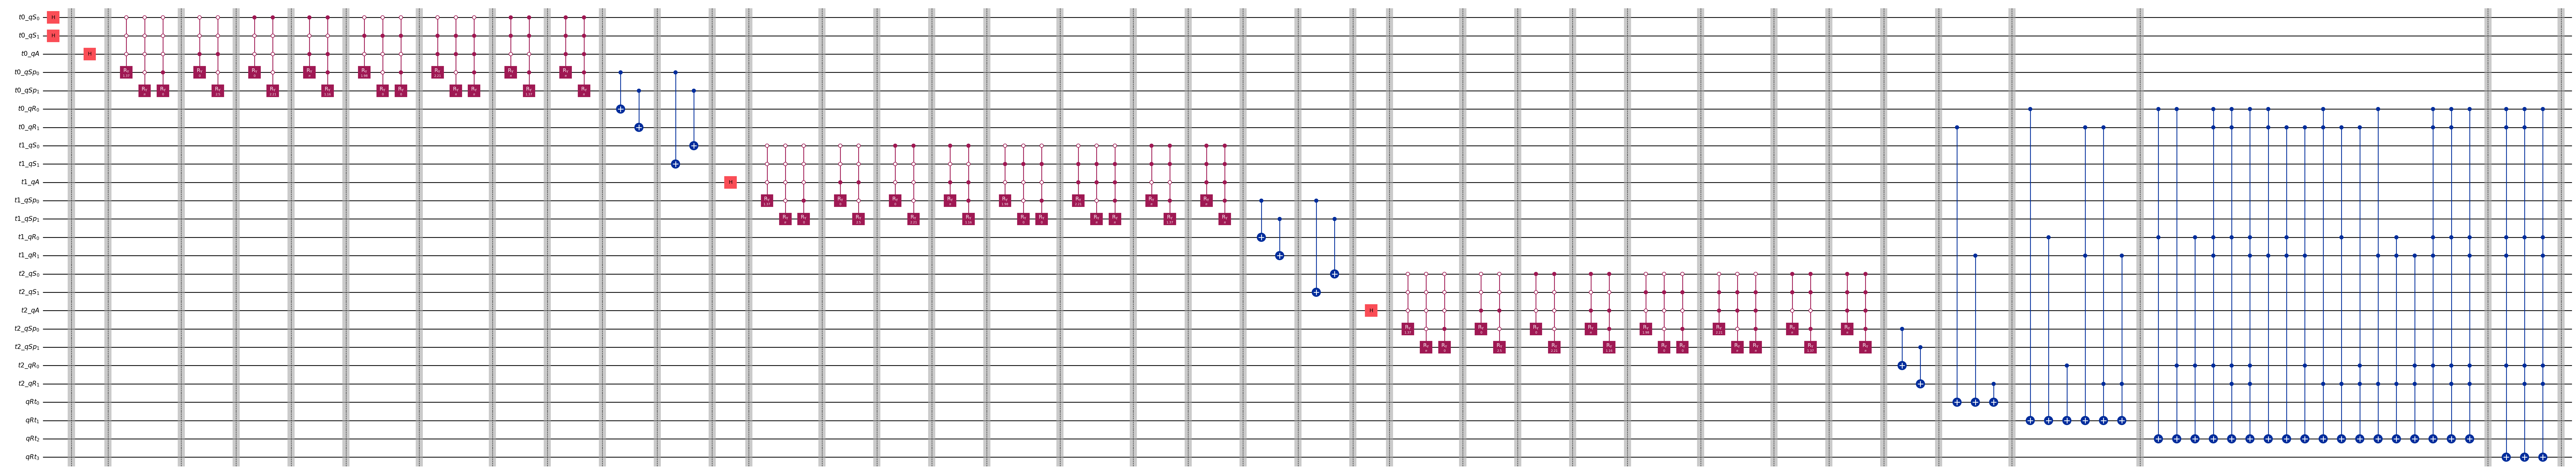

In [ ]:
# Instantiate environment
env_R= QuantumToyEnv() 

### implement return function to "env" MDP circuit
__URt(env_R.qc, env_R.qR0[1], env_R.qR0[0], env_R.qR1[1],env_R.qR1[0],env_R.qR2[1],env_R.qR2[0],env_R.qRt[0],env_R.qRt[1],env_R.qRt[2],env_R.qRt[3]) 

mdp_two_states_return = env_R.qc
mdp_two_states_return.draw('mpl', fold= 1)

In [7]:
mdp_two_states_return.num_qubits

25

In [8]:
# classical measurement 
mdp_two_states_return.measure_all()

In [ ]:
# Simulate the circuit to obtain measurement results
backend = AerSimulator(method = 'statevector')
transpile_circ = transpile(mdp_two_states_return, backend)

# Run and get counts
result = backend.run(transpile_circ).result()
counts_mdp = result.get_counts(transpile_circ)
# plot_histogram(counts_mdp, title='Measurement')

In [ ]:
# Correcting Next state qubits and reward qubits order
print ('counts_mdp:',counts_mdp) 

# Function to reverse the four most significant bits
def reverse_qubit_order_msb(value):
    if len(value) >= 4:
        most_significant_four = value[:4]
        rest = value[4:]
        reversed_most_significant_four = most_significant_four[::-1]
        return reversed_most_significant_four + rest
    return value

def correct_qubit_order(value):
     if len(value) >= 21:
         # return
         rt = value[:4] 
         # for t2
         t2 = value[4:11]
         t2_msb = reverse_qubit_order_msb(t2)
         # for t1
         t1 = value[11:18]
         t1_msb = reverse_qubit_order_msb(t1)
         # for t0
         t0 = value[18:]
         t0_msb = reverse_qubit_order_msb(t0)
         return rt+t2_msb+ t1_msb + t0_msb
     return value

# Create a new dictionary with modified values
modified_counts_mdp = {correct_qubit_order(key): value for key, value in counts_mdp.items()}
print('modified_counts_mdp:',modified_counts_mdp) ## Next state qubits and reward qubits are in correct order.

counts_mdp: {'0011101000000000100101101': 4, '0101000001001010111111110': 7, '0011010110110101000000001': 6, '1000010101111111111111111': 21, '1000111111001010111111111': 11, '0100010110110100011010100': 24, '0001101000000001000000010': 1, '0010101000110101000000001': 6, '0010000001001010000000010': 2, '1000111111111111100101011': 15, '1001111111111111111111101': 12, '0110111111001011011010001': 16, '0011000001001011011010100': 6, '1001111111111111111111110': 31, '1000111111001010111111110': 11, '0011101000110100011010100': 16, '0010000010000000100101010': 2, '0011101010000000100101101': 9, '0110010101111111011010100': 7, '0011101011001010000000100': 1, '0100101011001011011010001': 4, '0010000000110100011010100': 7, '0011101000110100011010001': 19, '0110010101111111011010001': 8, '0110010101001010100101011': 11, '0011101010000000100101010': 8, '0111111111001010100101101': 10, '0111010101111111100101101': 14, '0001000000110101000000010': 4, '0110101011001010111111111': 7, '0110111111001

In [14]:
modified_counts_mdp_sorted = dict(sorted(modified_counts_mdp.items(), key= lambda item: item[0], reverse= False))
# modified_counts_mdp_sorted

top_10_values:                 Quantum States  Count
168  1001111111111111111111110     31
169  1001111111111111111111111     28
73   0100101010101010010101100     24
140  1000101001111111111111110     21
141  1000101001111111111111111     21
114  0110111111010101010101100     20
153  1000111111111111101010101     20
40   0011010100101010010101001     19
71   0100101010101010010101000     19
87   0101101001010101010101100     19


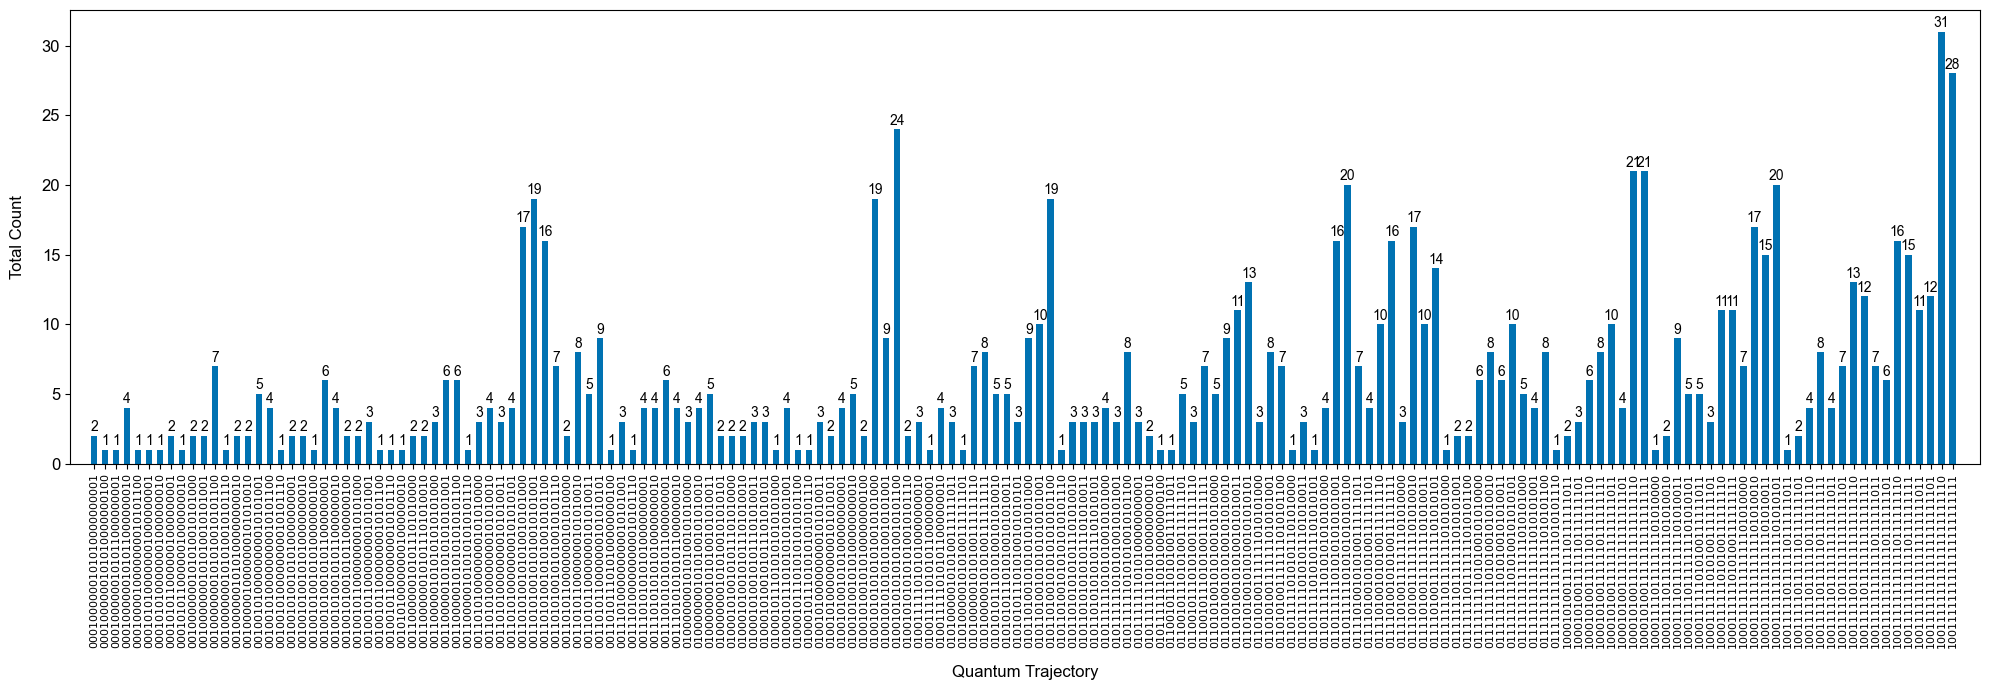

In [ ]:
qStates = list(modified_counts_mdp_sorted.keys()) 
count = list(modified_counts_mdp_sorted.values())

# Create a DataFrame 
df = pd.DataFrame({
     'Quantum States': qStates,
    'Count': count
})

# Identify the top 10 values and their indices
top_10_indices = df.nlargest(10, 'Count').index  
top_10_values = df.loc[top_10_indices]
print('top_10_values:',top_10_values)

top_colors  = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
df['Color'] = ('#0072B2')


# make a plot
fig, ax = plt.subplots(figsize=(20, 7))

# Define the width of the bars 
bar_width = 0.6 # pdf

# Create the bar chart
bars = ax.bar(df['Quantum States'], df['Count'], color=df['Color'], width=bar_width)

# Set the labels and title
ax.set_xlabel('Quantum Trajectory', fontsize = 12, fontfamily ='Arial', labelpad= 12)
ax.set_ylabel('Total Count', fontsize = 12, fontfamily ='Arial', labelpad= 12)


# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize = 8)
plt.yticks(rotation=0, fontsize = 12, fontfamily='Arial')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height+ 0.1 , f'{height:.0f}', ha='center', va='bottom', fontsize ='medium', rotation = 0, fontfamily ='Arial')

# Add space on the left and right
left_padding = -2.2  # Add more space to the left
right_padding = len(df['Quantum States']) - 0.5 + 2  # Add more space to the right
ax.set_xlim(left_padding, right_padding)

# Show the plot
plt.tight_layout()
plt.show()

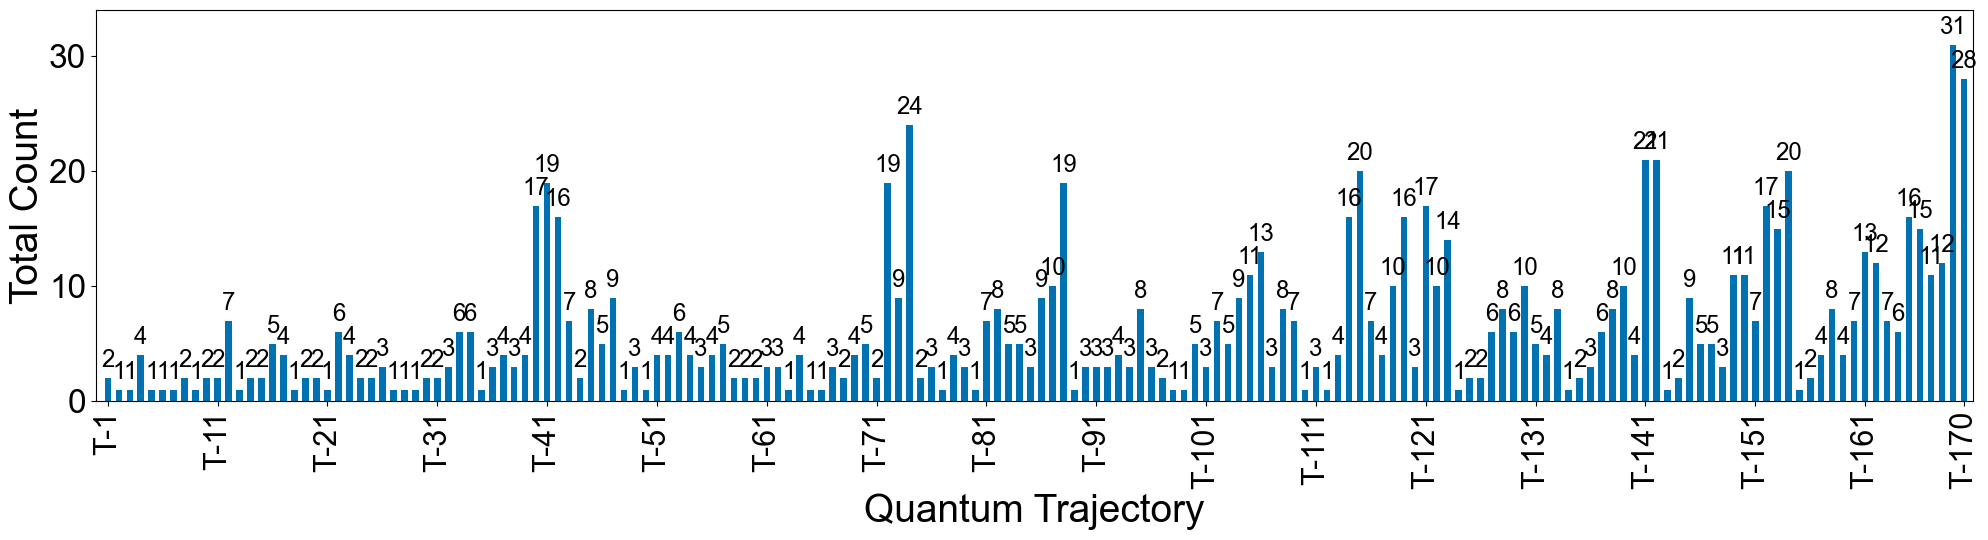

In [ ]:
###### x axis label changed 

# Quantum States and Counts
qStates = list(modified_counts_mdp_sorted.keys()) 
count = list(modified_counts_mdp_sorted.values())

# Create a DataFrame
df = pd.DataFrame({
    'Quantum States': qStates,
    'Count': count
})

df.index = range(1, len(df) + 1) # setting data frame index starting from 1 not 0
# Add an index column for sequential numbering
df['Index'] = range(1, len(df) + 1)

# Identify the top 10 values and their indices
top_10_indices = df.nlargest(10, 'Count').index  
top_10_values = df.loc[top_10_indices]
# print('top_10_values:',top_10_values)

top_colors  = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']

# Assign colors (optional for customization)
df['Color'] = '#0072B2'

# make a plot
fig, ax = plt.subplots(figsize=(20, 5.5))

# Define the width of the bars 
bar_width = 0.6 # pdf

# Create the bar chart
bars = ax.bar(df['Index'], df['Count'], color=df['Color'], width=bar_width)

# Set labels and title
ax.set_xlabel('Quantum Trajectory', fontsize=28, fontfamily='Arial', labelpad=3)
ax.set_ylabel('Total Count', fontsize=28, fontfamily='Arial', labelpad=2)

# Generate x-axis tick labels: every 10th tick + include the last label
tick_interval = 10
max_index = df['Index'].max()
selected_indices = list(range(1, max_index + 1, tick_interval))  # Every 10th tick
if max_index not in selected_indices:  # Include last index if not already there
    selected_indices.append(max_index)

# Generate labels for the selected indices
t_plus_labels = [f'T-{i}' for i in selected_indices]

# Update x-axis ticks and labels
plt.xticks(selected_indices, t_plus_labels, rotation=90, fontsize=22, fontfamily='Arial')

ax.set_yticks(range(0, int(df['Count'].max()) + 1, 10))  # Tick range: 0 to max, step = 5
plt.yticks(rotation=0, fontsize=24, fontfamily='Arial')

###Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.0f}', ha='center', va='bottom', fontsize='xx-large', rotation=0, fontfamily='Arial')
    
# Add space on the left and right
left_padding = -0.1  # Add more space to the left
right_padding = len(df['Index']) - 0.5 + 1.3  # Add more space to the right
ax.set_xlim(left_padding, right_padding)

# Adjust Y-Axis Limit to Add Padding
y_max = max(df['Count'])  # Maximum value in the dataset
ax.set_ylim(0, y_max + 3)  # Add some padding above the tallest bar

plt.tight_layout()

# plt.savefig('Quantum Trajectories in a Quantum Markov Decision Process for Three Timesteps_xaxis.png', dpi=800, format='png')  
# plt.savefig('Quantum Trajectories in a Quantum Markov Decision Process for Three Timesteps_xaxis.pdf', format='pdf')
plt.show()


---